In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from tabulate import tabulate
from tkinter import Tk, filedialog, simpledialog, messagebox
import statsmodels.api as sm
import BiQ_Common_Fxns as BiQ
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [163]:
# Set font sizes
title_fontsize = 16
label_fontsize = 14
legend_fontsize = 14
tick_label_fontsize = 12

c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\ChrisSaid\anaconda3\envs\BiQ_env_20231205\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


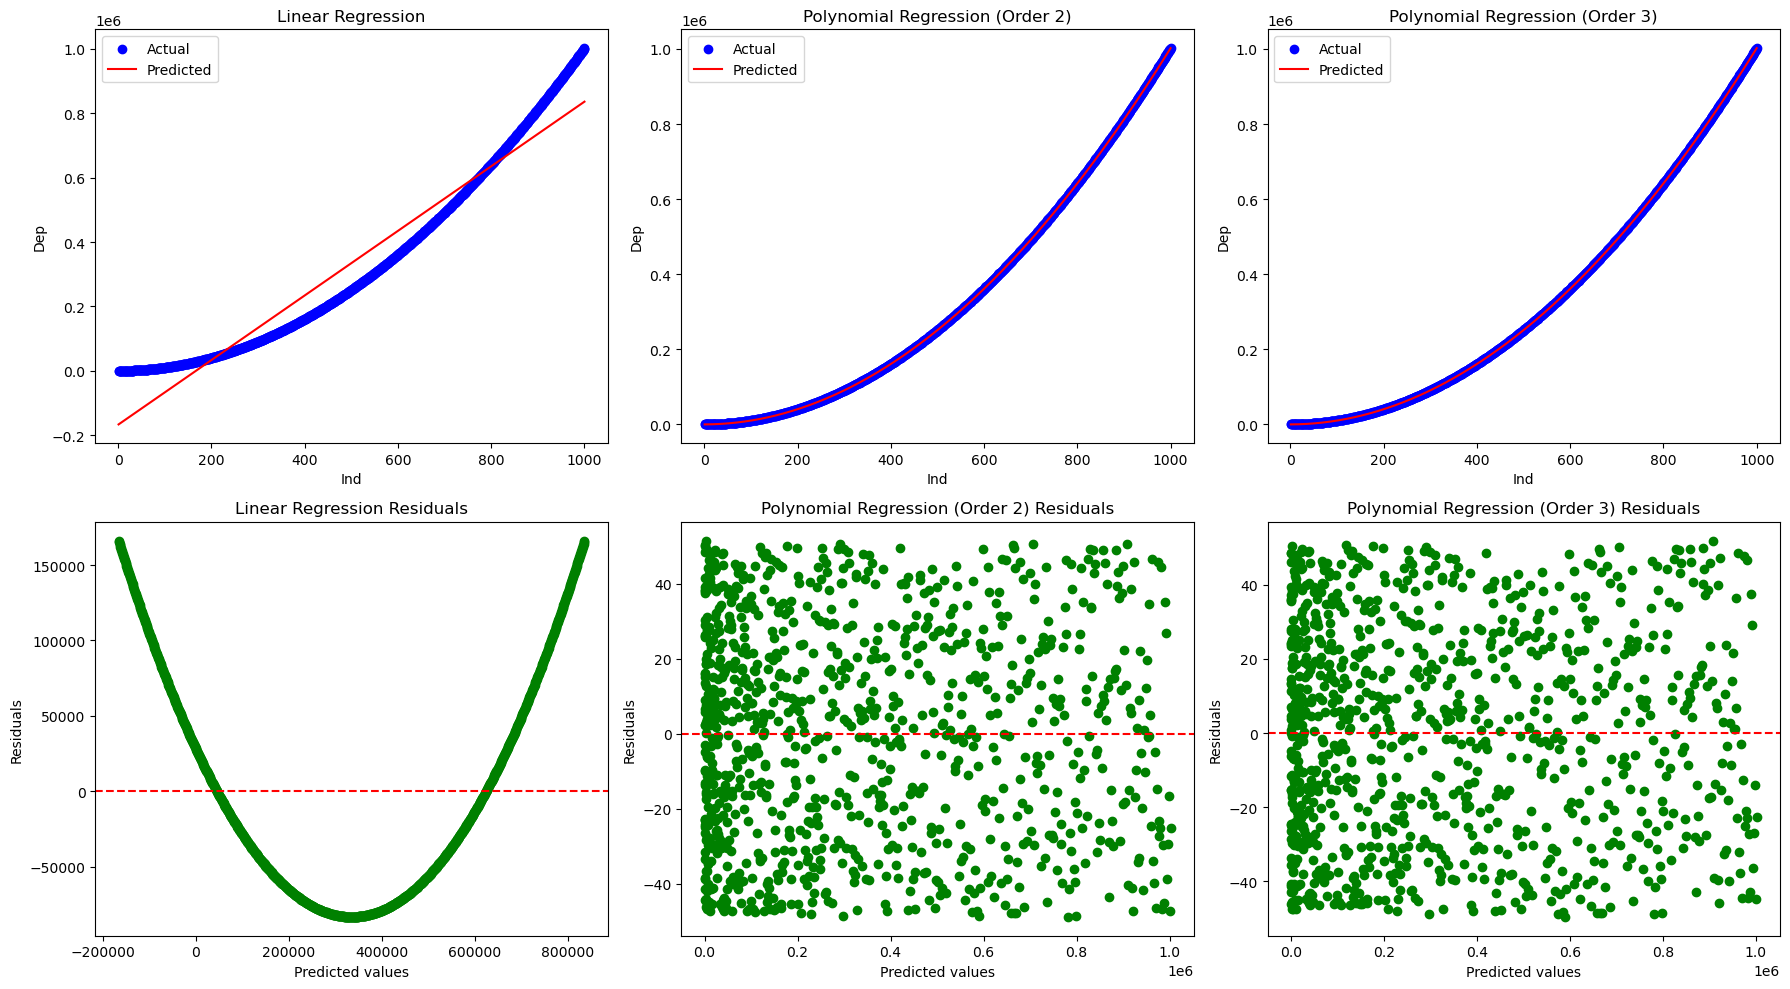

In [164]:
def read_excel_file(file_path):
    """Reads an Excel file and returns a DataFrame."""
    try:
        df = pd.read_excel(file_path)
        df = df.dropna(axis=1, how='all')
        return df
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        return None

def get_file_path():
    """Open file dialog and return selected file path."""
    root = Tk()
    root.withdraw()
    file_path = filedialog.askopenfilename(filetypes=[("Excel files", "*.xlsx"), ("All files", "*.*")])
    root.destroy()  # Close the Tkinter window
    return file_path

def get_user_column_selection(df, title):
    """Gets user input for selecting a column using dialog boxes."""
    columns = df.columns.tolist()
    root = Tk()
    root.withdraw()
    col_name = simpledialog.askstring(title, f"Enter the column name for {title}:\nAvailable columns: {', '.join(columns)}\n")
    root.destroy()  # Close the Tkinter window
    return col_name

def fit_linear_regression(df, x_col, y_col):
    """Fit a linear regression model."""
    X = df[[x_col]]
    X = sm.add_constant(X)  # Add constant for intercept
    y = df[y_col]

    model = sm.OLS(y, X).fit()
    return model

def fit_polynomial_regression(df, x_col, y_col, degree):
    """Fit a polynomial regression model."""
    X = df[[x_col]]
    y = df[y_col]

    polynomial_features = PolynomialFeatures(degree=degree)
    X_poly = polynomial_features.fit_transform(X)

    model = sm.OLS(y, X_poly).fit()
    return model, polynomial_features  # Return model and polynomial features

def plot_regression(model, X, y, title, axes, poly_features=None):
    """Plot regression results."""
    feature_col = X.columns[0]
    X_feature = X[feature_col].values.reshape(-1, 1)  # Convert X to numpy array

    if poly_features is not None:
        X_poly = poly_features.transform(X_feature)  # Transform X_feature
    else:
        X_poly = X_feature  # Use X_feature directly if poly_features is None

    axes.scatter(X_feature[:, 0], y, color='blue', label='Actual', marker='o')
    y_pred = model.predict(sm.add_constant(X_poly))  # Add constant for linear regression
    axes.plot(X_feature[:, 0], y_pred, color='red', label='Predicted')
    axes.set_title(title)D
    
    # Set X and Y labels dynamically based on column names
    axes.set_xlabel(X.columns[0])
    axes.set_ylabel(y.name)  # Assuming y is a pandas Series with a name attribute
    
    axes.legend()


def plot_residuals(model, X, y, title, axes, poly_features=None):
    """Plot residuals."""
    
    feature_col = X.columns[0]
    X_feature = X[feature_col].values.reshape(-1, 1)  # Convert X to numpy array

    if poly_features is not None:
        X_poly = poly_features.transform(X_feature)  # Transform X_feature
    else:
        X_poly = X_feature  # Use X_feature directly if poly_features is None

    y_pred = model.predict(sm.add_constant(X_poly))  # Calculate y_pred

    # Calculate residuals by subtracting actual y from predicted y
    residuals = y.values.reshape(-1) - y_pred

    # Plot residuals
    axes.scatter(y_pred, residuals, color='green', marker='o')
    axes.axhline(y=0, color='red', linestyle='--')  # Add horizontal line at y=0
    axes.set_xlabel('Predicted values')
    axes.set_ylabel('Residuals')
    axes.set_title(title)



def main():
    file_path = get_file_path()
    if not file_path:
        print("No file selected.")
        return

    df = read_excel_file(file_path)
    if df is None:
        print("Error reading Excel file.")
        return

    x_col = get_user_column_selection(df, "Independent Variable (X)")
    if x_col is None:
        print("Error: Invalid input for independent variable.")
        return

    y_col = get_user_column_selection(df, "Dependent Variable (Y)")
    if y_col is None:
        print("Error: Invalid input for dependent variable.")
        return

    linear_model = fit_linear_regression(df, x_col, y_col)
    poly2_model, poly2_features = fit_polynomial_regression(df, x_col, y_col, degree=2)
    poly3_model, poly3_features = fit_polynomial_regression(df, x_col, y_col, degree=3)

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))  # Adjusted subplot size to accommodate 3 plots in the second row

    plot_regression(linear_model, df[[x_col]], df[y_col], "Linear Regression", axs[0, 0])
    plot_regression(poly2_model, df[[x_col]], df[y_col], "Polynomial Regression (Order 2)", axs[0, 1], poly2_features)
    plot_regression(poly3_model, df[[x_col]], df[y_col], "Polynomial Regression (Order 3)", axs[0, 2], poly3_features)

    plot_residuals(linear_model, df[[x_col]], df[y_col], "Linear Regression Residuals", axs[1, 0])
    plot_residuals(poly2_model, df[[x_col]], df[y_col], "Polynomial Regression (Order 2) Residuals", axs[1, 1], poly2_features)
    plot_residuals(poly3_model, df[[x_col]], df[y_col], "Polynomial Regression (Order 3) Residuals", axs[1, 2], poly3_features)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
